$V(x)=\sum_{t=1}^T R(x(t))$ \
where  $R(x)=-\|x-x_{goal}\|-variance$ \
and $T=15$

Use all datas 

# Create Environment

In [29]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from tqdm import tqdm

global N

N=50

global M
M=10

global T
global target
T=15
target=np.array([3,2])
global w
w=np.pi*2/23.7

global delta_t
delta_t=T/N

global beta
beta=[0.95,0.975,1,1.025,1.05]

global num_system
num_system=5

global obs_para
obs_para=6

global coeff
coeff=[]
for i in range(N+1):
    coeff.append(0.2**(i%10))
print(coeff)

[1.0, 0.2, 0.04000000000000001, 0.008000000000000002, 0.0016000000000000003, 0.0003200000000000001, 6.400000000000002e-05, 1.2800000000000005e-05, 2.5600000000000013e-06, 5.120000000000002e-07, 1.0, 0.2, 0.04000000000000001, 0.008000000000000002, 0.0016000000000000003, 0.0003200000000000001, 6.400000000000002e-05, 1.2800000000000005e-05, 2.5600000000000013e-06, 5.120000000000002e-07, 1.0, 0.2, 0.04000000000000001, 0.008000000000000002, 0.0016000000000000003, 0.0003200000000000001, 6.400000000000002e-05, 1.2800000000000005e-05, 2.5600000000000013e-06, 5.120000000000002e-07, 1.0, 0.2, 0.04000000000000001, 0.008000000000000002, 0.0016000000000000003, 0.0003200000000000001, 6.400000000000002e-05, 1.2800000000000005e-05, 2.5600000000000013e-06, 5.120000000000002e-07, 1.0, 0.2, 0.04000000000000001, 0.008000000000000002, 0.0016000000000000003, 0.0003200000000000001, 6.400000000000002e-05, 1.2800000000000005e-05, 2.5600000000000013e-06, 5.120000000000002e-07, 1.0]


In [30]:
def Z(vecs, u, v):
    output=[]
    for i in range(num_system):
        vec=vecs[i]
        x=vec[0]
        y=vec[1]
        theta=vec[2]
        output.append([beta[i]*np.cos(theta)*u,beta[i]*np.sin(theta)*u,beta[i]*v])
    return np.array(output)

#check the correctness of Z
'''
x = np.linspace(0, 6.5, 1001)
plt.plot(x, Z(x))
plt.xlabel('Angle [rad]')
plt.ylabel('Z(theta)')
plt.grid()
plt.show()
'''

"\nx = np.linspace(0, 6.5, 1001)\nplt.plot(x, Z(x))\nplt.xlabel('Angle [rad]')\nplt.ylabel('Z(theta)')\nplt.grid()\nplt.show()\n"

In [31]:
def next_step(vecs,action):  
    u=action[0]
    v=action[1]
   
    for j in range(M):
        vecs_new=[]
        diff=Z(vecs,u,v)
        for i in range(num_system):
            w=vecs[i]+delta_t/M*diff[i]
            '''
            if w[2]>np.pi:
                w[2]-=2*np.pi
            if w[2]<-np.pi:
                w[2]+=2*np.pi
            '''
            vecs_new.append(w)
        vecs=np.array(vecs_new)
    return vecs

def observe(vecs):
    mu_x=0
    mu_y=0
    mu_theta=0
    var_x=0
    var_y=0
    var_theta=0
    for i in range(num_system):
        mu_x+=vecs[i][0]
        mu_y+=vecs[i][1]
        mu_theta+=vecs[i][2]
        var_x+=vecs[i][0]**2
        var_y+=vecs[i][1]**2
        var_theta+=vecs[i][2]**2
    var_x-=mu_x**2/num_system
    var_y-=mu_y**2/num_system
    var_theta-=mu_theta**2/num_system
    
    w=np.array([mu_x,mu_y,mu_theta,var_x,var_y,var_theta])/num_system
    if w[2]>np.pi:
        w[2]-=2*np.pi
    if w[2]<-np.pi:
        w[2]+=2*np.pi
    return w

def reward(obs):
    return max(10-np.sqrt((obs[0]-target[0])**2+(obs[1]-target[1])**2)-10*obs[3]-10*obs[4],0)

def reward_raw(position):
    r=0
    for i in range(num_system):
        r+=np.linalg.norm(position[i,[0,1]]-target)
    return r

def value_func(funcs,flags,next_state):
    result=[]
    for i in range(6):
        if flags[i]:
            result.append(0)
        else:
            k,_=funcs[i].predict(next_state.reshape(-1,obs_para), return_std=True)
            result.append(k[0])
    result=np.array(result)
    return np.max(result)

# Learning Settings

In [32]:
global lr
lr=0.01
global eps
eps=0.2
global max_u
max_u=2
global precision
precision=0.0002
global action_set
action_set=np.array([[1,np.pi/4],[-1,np.pi/4],[1,0],[-1,0],[1,-np.pi/4],[-1,-np.pi/4]])

def exploration():
    a=np.random.uniform()
    if a<eps:
        return True
    else:
        return False

def find_max(cand):
    return np.argmax(cand)
    
def decide_u(funcs,flags,state,init=False):
    explo=exploration()
    if init or explo:
        return np.random.randint(6)
    else:
        result=[]
        for i in range(6):
            if flags[i]:
                return i
            else:
                k,_=funcs[i].predict(state.reshape(-1,obs_para), return_std=True)
                result.append(k[0])
    result=np.array(result)
    return np.argmax(result)
    
def decide_u_exploitation(funcs,flags,state,init=False):
    result=[]
    for i in range(6):
        if flags[i]:
            print("Err",i)
            return i
        else:
            k,_=funcs[i].predict(state.reshape(-1,obs_para), return_std=True)
            result.append(k[0])
    result=np.array(result)
    return np.argmax(result)

history_su=[0 for i in range(6)]
history_r=[0 for i in range(6)]
history_su_next=[0 for i in range(6)]
flags=[True for i in range(6)]

history_rt=[[[] for i in range(6)] for j in range(N+1)]
history_sut=[[[] for i in range(6)] for j in range(N+1)]
flags_t=[[True for i in range(6)] for j in range(N+1)]

# Simulation


In [33]:
num_iter=100

position_result=[]
observation_result=[]
gpr_list=[[0 for i in range(6)] for j in range(N+1)]

best_r=-10000
best_obs=[]
best_pos=[[] for i in range(num_system)]
best_u=[]

for iterr in tqdm(range(num_iter)):
    #initialize
    position=np.array([[-2,-2,0] for _ in range(num_system)])
    observation=observe(position)
    u_t=[]
    r_t=[]
    observation_t=[observation]
    position_t=[[] for i in range(num_system)]
    
    
    history_target=[0 for i in range(6)]
    
    
    for time in range(N+1):
        if iterr<5:
            #candidates_u=[]
            u_k = decide_u(gpr_list[time],flags,observation,init=True)
            position_new = next_step(position,action_set[u_k])
            observation_new = observe(position_new)
            r = reward(observation_new)
            r_t.append(r)
            
            if flags[u_k]:
                history_su[u_k] = observation.reshape(-1,obs_para)
                history_su_next[u_k] = observation_new.reshape(-1,obs_para)  
                history_r[u_k] = np.array([r])
                flags[u_k]=False
            else:
                history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,obs_para)))
                history_su_next[u_k] = np.concatenate((history_su_next[u_k], observation_new.reshape(-1,obs_para)))
                history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            
            
            observation=observation_new
            position=position_new
            u_t.append(u_k)
            observation_t.append(observation)
            for i in range(num_system):
                position_t[i].append(position[i])
            
            
        else:
            #candidates_u=[]
            u_k = decide_u(gpr_list[time],flags,observation)
            #print(candidates_u)
            #u_k, explo = decide_u(observation,np.array(candidates_u))
            
            position_new = next_step(position,action_set[u_k])
            observation_new = observe(position_new)
            r = reward(observation_new)
            r_t.append(r)
            
            history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,obs_para)))
            history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            history_su_next[u_k] = np.concatenate((history_su_next[u_k], observation_new.reshape(-1,obs_para)))
            
            observation=observation_new
            position=position_new
            u_t.append(u_k)
            observation_t.append(observation)
            for i in range(num_system):
                position_t[i].append(position[i])
            
            
            
            
    #update
    #calculate cumulative r 
    

    '''
    for j in range(6):
        history_target[j]=last_coeff*history_r[u_t[-i]]
        gpr_list[-i][j]=GaussianProcessRegressor(alpha=1e-4).fit(history_su[j], history_target[j])
    '''  
         
    #TODO
       
    for i in range(N+1):
        if i==1:
            for j in range(6):
                history_target[j]=coeff[-1]*history_r[j]
                gpr_list[-i][j]=GaussianProcessRegressor(alpha=1e-5).fit(np.array(history_su[j]).reshape(-1,obs_para), history_target[j].reshape(-1,1))
            
        elif i>1:
            for j in range(6):
                history_tar=[]
                for k in range(history_r[j].shape[0]):
                    history_tar.append(coeff[N+1-i]*history_r[j][k]+value_func(gpr_list[-i+1],flags_t[-i+1],history_su_next[j][k]))
                gpr_list[-i][j]=GaussianProcessRegressor(alpha=1e-5).fit(np.array(history_su[j]).reshape(-1,obs_para), np.array(history_tar).reshape(-1,1))
            '''
            r_t[-i]=0.5**(N+1-i)*r_t[-i]+value_func(gpr_list[-i+1],flags_t[-i+1],observation_t[-i+1])
            history_rt[-i][u_t[-i]].append(r_t[-i])
            history_sut[-i][u_t[-i]].append(observation_t[-i])
            gpr_list[-i][u_t[-i]]=GaussianProcessRegressor(alpha=1e-4).fit(np.array(history_sut[-i][u_t[-i]]).reshape(-1,5), np.array(history_rt[-i][u_t[-i]]).reshape(-1,1))
            if flags_t[-i][u_t[-i]]:
                flags_t[-i][u_t[-i]]=False
            '''
    for j in range(6):
        history_tar=[]
        for k in range(history_r[j].shape[0]):
            history_tar.append(coeff[0]*history_r[j][k]+value_func(gpr_list[1],flags_t[1],history_su_next[j][k]))
        gpr_list[0][j]=GaussianProcessRegressor(alpha=1e-5).fit(np.array(history_su[j]).reshape(-1,obs_para), np.array(history_tar).reshape(-1,1))

            
        
    print("observation =",observation)
    #print(observation_t)
    position_result.append(position)
    observation_result.append(observation)
    if r>best_r:
        best_r=r
        best_obs=observation_t
        best_pos=position_t
        best_u=u_t
    
    #print(history_su.shape)
    #print(u_t)

  1%|▊                                                                                 | 1/100 [00:00<00:37,  2.61it/s]

observation = [-1.27413175e+00 -1.16172875e+00 -1.17809725e+00  1.03788935e-02
  1.58755814e-04  1.73489140e-03]


  2%|█▋                                                                                | 2/100 [00:00<00:38,  2.54it/s]

observation = [-4.81666517e-01 -1.62826237e+00  9.42477796e-01  2.88292951e-03
  8.49009207e-04  1.11033050e-03]


  3%|██▍                                                                               | 3/100 [00:01<00:43,  2.25it/s]

observation = [-2.24743393e+00 -2.55688227e+00 -1.41371669e+00  1.67895140e-03
  5.32020300e-04  2.49824361e-03]


  4%|███▎                                                                              | 4/100 [00:01<00:47,  2.03it/s]

observation = [-1.30698835e+00 -2.99254852e+00  1.88495559e+00  2.88825818e-03
  4.27298630e-03  4.44132198e-03]


  5%|████                                                                              | 5/100 [00:02<00:49,  1.94it/s]

observation = [-2.13842963e+00 -2.84465946e+00  7.06858347e-01  1.68233555e-03
  1.40074900e-03  6.24560904e-04]


  6%|████▉                                                                             | 6/100 [00:02<00:49,  1.91it/s]

observation = [9.48908086e-01 2.78003362e-01 2.82743339e+00 1.05296626e-04
 1.28456095e-02 9.99297446e-03]


  7%|█████▋                                                                            | 7/100 [00:03<00:50,  1.86it/s]

observation = [1.00315632e+00 8.52517433e-01 2.59181394e+00 2.31860147e-04
 9.03213317e-03 8.39687437e-03]


  8%|██████▌                                                                           | 8/100 [00:04<00:51,  1.77it/s]

observation = [-8.05300590e-01 -5.20622144e-01  1.64933614e+00  1.65802662e-04
  6.31710913e-03  3.40038714e-03]


  9%|███████▍                                                                          | 9/100 [00:04<00:53,  1.69it/s]

observation = [ 2.54619498 -1.27308651 -0.15707963  0.29181325  0.07448537  0.04691146]


 10%|████████                                                                         | 10/100 [00:05<00:56,  1.61it/s]

observation = [ 0.93307888  0.79868727 -1.57079633  0.00178719  0.0312173   0.02775826]


 11%|████████▉                                                                        | 11/100 [00:06<00:58,  1.51it/s]

observation = [ 9.62526752e-01  1.64122822e+00 -2.27765467e+00  1.21866098e-03
  7.33825666e-03  2.00553446e-02]


 12%|█████████▋                                                                       | 12/100 [00:07<01:02,  1.42it/s]

observation = [2.11815939 0.97310271 1.88495559 0.00301133 0.04294126 0.00444132]


 13%|██████████▌                                                                      | 13/100 [00:07<01:05,  1.34it/s]

observation = [ 1.16417792 -0.23883005  2.35619449  0.00995575  0.03095744  0.00693957]


 14%|███████████▎                                                                     | 14/100 [00:08<01:08,  1.25it/s]

observation = [4.96173298e-01 1.66999001e-01 2.35619449e+00 2.66618303e-04
 1.11809216e-02 6.93956559e-03]


 15%|████████████▏                                                                    | 15/100 [00:09<01:12,  1.18it/s]

observation = [1.60139737e+00 1.15989894e+00 2.82743339e+00 1.34883317e-03
 5.21025458e-02 9.99297446e-03]


 16%|████████████▉                                                                    | 16/100 [00:10<01:15,  1.11it/s]

observation = [8.41545700e-01 1.51073975e+00 1.88495559e+00 1.17994106e-03
 3.29275862e-02 4.44132198e-03]


 17%|█████████████▊                                                                   | 17/100 [00:11<01:19,  1.04it/s]

observation = [1.82424679e+00 1.65762195e+00 2.35619449e+00 4.30246405e-04
 6.25598549e-02 6.93956559e-03]


 18%|██████████████▌                                                                  | 18/100 [00:13<01:22,  1.01s/it]

observation = [1.41967250e+00 1.24380416e+00 2.35619449e+00 6.94252069e-04
 5.04789418e-02 6.93956559e-03]


 19%|███████████████▍                                                                 | 19/100 [00:14<01:29,  1.10s/it]

observation = [ 6.80023317e-01 -1.11780101e-01 -1.57079633e+00  6.83717952e-02
  7.69543093e-04  2.77582624e-02]


 20%|████████████████▏                                                                | 20/100 [00:15<01:34,  1.19s/it]

observation = [1.80173493e+00 1.34974177e+00 2.12057504e+00 1.71538157e-03
 4.69735670e-02 5.62104813e-03]


 21%|█████████████████                                                                | 21/100 [00:17<01:40,  1.27s/it]

observation = [1.78379638e+00 1.77520940e+00 2.35619449e+00 3.60245932e-04
 4.80835344e-02 6.93956559e-03]


 22%|█████████████████▊                                                               | 22/100 [00:18<01:45,  1.35s/it]

observation = [1.97608661e+00 1.71932676e+00 1.64933614e+00 9.94472077e-04
 5.02227506e-02 3.40038714e-03]


 23%|██████████████████▋                                                              | 23/100 [00:20<01:49,  1.43s/it]

observation = [2.5149807  1.41691609 2.59181394 0.00679768 0.06884832 0.00839687]


 24%|███████████████████▍                                                             | 24/100 [00:22<01:55,  1.52s/it]

observation = [1.86327935e+00 1.26808985e+00 2.35619449e+00 1.65448086e-03
 4.73095127e-02 6.93956559e-03]


 25%|████████████████████▎                                                            | 25/100 [00:23<02:01,  1.63s/it]

observation = [ 1.26009617  1.29847371 -2.51327412  0.00860169  0.00526916  0.01776529]


 26%|█████████████████████                                                            | 26/100 [00:25<02:07,  1.73s/it]

observation = [2.09552738e+00 2.20869858e+00 1.64933614e+00 1.43142802e-04
 5.79223718e-02 3.40038714e-03]


 27%|█████████████████████▊                                                           | 27/100 [00:27<02:12,  1.81s/it]

observation = [2.35397561e+00 2.10997930e+00 1.64933614e+00 1.05115047e-03
 6.00688603e-02 3.40038714e-03]


 28%|██████████████████████▋                                                          | 28/100 [00:30<02:20,  1.94s/it]

observation = [2.14850862e+00 1.66372211e+00 1.64933614e+00 1.74849140e-04
 4.23994321e-02 3.40038714e-03]


 29%|███████████████████████▍                                                         | 29/100 [00:32<02:26,  2.06s/it]

observation = [2.29619161e+00 2.16593989e+00 7.06858347e-01 5.12416843e-04
 6.27596694e-02 6.24560904e-04]


 30%|████████████████████████▎                                                        | 30/100 [00:34<02:31,  2.16s/it]

observation = [2.91374469 1.87732408 1.64933614 0.00617654 0.06398148 0.00340039]


 31%|█████████████████████████                                                        | 31/100 [00:37<02:36,  2.27s/it]

observation = [2.56796149e+00 1.45861649e+00 9.42477796e-01 6.88784746e-03
 5.26416786e-02 1.11033050e-03]


 32%|█████████████████████████▉                                                       | 32/100 [00:40<02:41,  2.38s/it]

observation = [2.72098630e+00 2.03066804e+00 9.42477796e-01 3.78967186e-03
 6.58382777e-02 1.11033050e-03]


 33%|██████████████████████████▋                                                      | 33/100 [00:42<02:46,  2.48s/it]

observation = [3.14923099e+00 2.40378535e+00 4.71238898e-01 4.22198670e-03
 7.82405247e-02 2.77582624e-04]


 34%|███████████████████████████▌                                                     | 34/100 [00:45<02:51,  2.60s/it]

observation = [ 3.22181310e+00  2.20171671e+00 -1.80411242e-17  5.43869339e-03
  7.00470029e-02  5.09601063e-33]


 35%|████████████████████████████▎                                                    | 35/100 [00:48<02:54,  2.69s/it]

observation = [2.87681330e+00 1.74527297e+00 2.35619449e-01 5.98916451e-03
 5.73131517e-02 6.93956559e-05]


 36%|█████████████████████████████▏                                                   | 36/100 [00:51<02:59,  2.80s/it]

observation = [ 2.5771416   1.91626875 -2.74889357  0.00469237  0.04277903  0.01561402]


 37%|█████████████████████████████▉                                                   | 37/100 [00:54<03:04,  2.92s/it]

observation = [3.33431676e+00 1.98609114e+00 1.17809725e+00 7.04479417e-03
 6.41979735e-02 1.73489140e-03]


 38%|██████████████████████████████▊                                                  | 38/100 [00:58<03:09,  3.06s/it]

observation = [2.54007499 1.83023322 3.06305284 0.00531136 0.03816635 0.01172787]


 39%|███████████████████████████████▌                                                 | 39/100 [01:01<03:16,  3.22s/it]

observation = [3.23460310e+00 2.36286283e+00 9.42477796e-01 5.47182421e-03
 7.76155680e-02 1.11033050e-03]


 40%|████████████████████████████████▍                                                | 40/100 [01:05<03:21,  3.36s/it]

observation = [3.03463588 2.0273598  2.59181394 0.00601818 0.07492282 0.00839687]


 41%|█████████████████████████████████▏                                               | 41/100 [01:09<03:29,  3.54s/it]

observation = [2.82681664e+00 1.84243371e+00 4.71238898e-01 5.22125670e-03
 6.02216250e-02 2.77582624e-04]


 42%|██████████████████████████████████                                               | 42/100 [01:14<03:43,  3.86s/it]

observation = [2.88220269e+00 1.84970179e+00 4.71238898e-01 5.97977940e-03
 6.16184564e-02 2.77582624e-04]


 43%|██████████████████████████████████▊                                              | 43/100 [01:18<03:56,  4.14s/it]

observation = [2.83477325e+00 1.91248277e+00 2.35619449e-01 5.30592092e-03
 6.29892329e-02 6.93956559e-05]


 44%|███████████████████████████████████▋                                             | 44/100 [01:24<04:09,  4.46s/it]

observation = [ 2.76916826e+00  1.96071181e+00 -6.93889390e-18  4.49527413e-03
  6.26733683e-02  1.36741026e-33]


 45%|████████████████████████████████████▍                                            | 45/100 [01:29<04:26,  4.85s/it]

observation = [2.07487474e+00 1.74561098e+00 1.17809725e+00 1.37301747e-03
 5.39954436e-02 1.73489140e-03]


 46%|█████████████████████████████████████▎                                           | 46/100 [01:35<04:30,  5.02s/it]

observation = [ 7.58015044e-01 -2.39919210e-01 -2.04203522e+00  2.75696755e-02
  1.15641465e-03  2.24841925e-02]


 47%|██████████████████████████████████████                                           | 47/100 [01:40<04:34,  5.19s/it]

observation = [2.81569517e+00 2.03870028e+00 6.93889390e-18 4.99785532e-03
 6.76095604e-02 1.82963345e-33]


 48%|██████████████████████████████████████▉                                          | 48/100 [01:46<04:38,  5.35s/it]

observation = [3.36823729e+00 2.02526647e+00 4.16333634e-18 7.60837230e-03
 6.64066626e-02 1.70637393e-33]


 49%|███████████████████████████████████████▋                                         | 49/100 [01:52<04:40,  5.50s/it]

observation = [2.85495174e+00 1.92508988e+00 7.06858347e-01 5.54801649e-03
 6.40728942e-02 6.24560904e-04]


 50%|████████████████████████████████████████▌                                        | 50/100 [01:58<04:48,  5.77s/it]

observation = [3.39227500e+00 2.16756880e+00 7.06858347e-01 7.90504809e-03
 7.27888341e-02 6.24560904e-04]


 51%|█████████████████████████████████████████▎                                       | 51/100 [02:05<04:56,  6.04s/it]

observation = [3.06248159 1.63295948 2.82743339 0.01093249 0.04771671 0.00999297]


 52%|██████████████████████████████████████████                                       | 52/100 [02:11<04:57,  6.19s/it]

observation = [2.83458980e+00 2.09545521e+00 4.71238898e-01 5.26174307e-03
 6.99586324e-02 2.77582624e-04]


 53%|██████████████████████████████████████████▉                                      | 53/100 [02:20<05:28,  6.99s/it]

observation = [ 3.25470975e+00  1.69204715e+00 -7.06858347e-01  5.84481894e-03
  5.38882818e-02  6.24560904e-04]


 54%|███████████████████████████████████████████▋                                     | 54/100 [02:28<05:36,  7.32s/it]

observation = [2.78311712e+00 1.95023919e+00 2.35619449e-01 4.61622172e-03
 6.34782496e-02 6.93956559e-05]


 55%|████████████████████████████████████████████▌                                    | 55/100 [02:37<05:41,  7.59s/it]

observation = [2.77804774e+00 1.88316865e+00 2.35619449e-01 4.54695267e-03
 6.09933258e-02 6.93956559e-05]


 56%|█████████████████████████████████████████████▎                                   | 56/100 [02:44<05:33,  7.58s/it]

observation = [ 1.00478229e+00  1.70889566e+00 -1.52655666e-17  6.11519758e-04
  4.31834571e-02  5.34252967e-33]


 57%|██████████████████████████████████████████████▏                                  | 57/100 [02:52<05:27,  7.62s/it]

observation = [ 2.76721559e+00  2.02923794e+00 -2.35619449e-01  4.39545583e-03
  6.63810444e-02  6.93956559e-05]


 58%|██████████████████████████████████████████████▉                                  | 58/100 [03:00<05:22,  7.68s/it]

observation = [2.73232344e+00 1.96906082e+00 9.42477796e-01 3.96587752e-03
 6.34868206e-02 1.11033050e-03]


 59%|███████████████████████████████████████████████▊                                 | 59/100 [03:10<05:41,  8.32s/it]

observation = [2.79076521e+00 2.00478711e+00 2.35619449e-01 4.68906845e-03
 6.58395941e-02 6.93956559e-05]


 60%|████████████████████████████████████████████████▌                                | 60/100 [03:19<05:42,  8.55s/it]

observation = [2.81286588e+00 1.89657717e+00 2.35619449e-01 4.97621009e-03
 6.23676850e-02 6.93956559e-05]


 61%|█████████████████████████████████████████████████▍                               | 61/100 [03:27<05:32,  8.53s/it]

observation = [2.77109290e+00 1.88706615e+00 2.35619449e-01 4.49882656e-03
 6.08410541e-02 6.93956559e-05]


 62%|██████████████████████████████████████████████████▏                              | 62/100 [03:36<05:24,  8.54s/it]

observation = [2.81968800e+00 1.88949626e+00 4.71238898e-01 5.08895720e-03
 6.19992797e-02 2.77582624e-04]


 63%|███████████████████████████████████████████████████                              | 63/100 [03:45<05:22,  8.72s/it]

observation = [2.81022661e+00 1.92788620e+00 4.71238898e-01 4.92834106e-03
 6.34425309e-02 2.77582624e-04]


 64%|███████████████████████████████████████████████████▊                             | 64/100 [03:54<05:18,  8.85s/it]

observation = [2.79989502e+00 1.91426705e+00 7.06858347e-01 4.81308224e-03
 6.26397620e-02 6.24560904e-04]


 65%|████████████████████████████████████████████████████▋                            | 65/100 [04:05<05:27,  9.37s/it]

observation = [ 2.82669098e+00  1.87796779e+00 -1.80411242e-17  5.19346995e-03
  6.16891778e-02  5.09601063e-33]


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [04:15<05:25,  9.57s/it]

observation = [2.97531023e+00 1.63557138e+00 1.17809725e+00 7.58372660e-03
 5.48658916e-02 1.73489140e-03]


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [04:25<05:23,  9.80s/it]

observation = [3.18237473 1.60980628 1.64933614 0.01088884 0.05850557 0.00340039]


 68%|███████████████████████████████████████████████████████                          | 68/100 [04:36<05:28, 10.27s/it]

observation = [ 5.44201155e+00 -1.87466757e+00  1.41371669e+00  1.47177926e-04
  5.11296486e-03  2.49824361e-03]


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [04:48<05:31, 10.68s/it]

observation = [2.79685363e+00 1.83848504e+00 4.16333634e-18 4.79656331e-03
 5.97179123e-02 1.70637393e-33]


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [04:59<05:28, 10.95s/it]

observation = [3.25164496e+00 2.16998918e+00 1.17809725e+00 5.84696287e-03
 6.96104076e-02 1.73489140e-03]


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [05:12<05:27, 11.28s/it]

observation = [3.38353131e+00 2.07700173e+00 2.35619449e-01 7.94419464e-03
 6.83239667e-02 6.93956559e-05]


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [05:24<05:25, 11.63s/it]

observation = [2.83122385e+00 1.91948203e+00 4.71238898e-01 5.23166897e-03
 6.33419444e-02 2.77582624e-04]


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [05:37<05:24, 12.04s/it]

observation = [2.89763394e+00 1.79029436e+00 4.71238898e-01 6.25617278e-03
 5.94781775e-02 2.77582624e-04]


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [05:51<05:28, 12.65s/it]

observation = [2.79820404e+00 1.84532195e+00 9.42477796e-01 4.95578500e-03
 5.94312334e-02 1.11033050e-03]


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [06:06<05:32, 13.31s/it]

observation = [2.74126422e+00 2.04188743e+00 7.06858347e-01 4.08077408e-03
 6.63174902e-02 6.24560904e-04]


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [06:19<05:20, 13.35s/it]

observation = [2.86309823e+00 1.76396960e+00 1.41371669e+00 5.89259925e-03
 5.74285287e-02 2.49824361e-03]


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [06:33<05:11, 13.54s/it]

observation = [2.75680757e+00 1.84741460e+00 7.06858347e-01 4.36731490e-03
 5.89114855e-02 6.24560904e-04]


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [06:49<05:13, 14.24s/it]

observation = [ 2.86378750e+00  1.67225537e+00 -2.35619449e-01  5.74957768e-03
  5.50031497e-02  6.93956559e-05]


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [07:07<05:19, 15.21s/it]

observation = [ 4.52598356e+00  1.74753670e+00 -7.06858347e-01  1.55723452e-02
  5.78759499e-02  6.24560904e-04]


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [07:24<05:19, 15.95s/it]

observation = [ 3.21408160e+00  2.15601264e+00 -2.35619449e-01  5.24968261e-03
  6.88121120e-02  6.93956559e-05]


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [07:39<04:58, 15.71s/it]

observation = [3.26342755e+00 1.97957639e+00 4.71238898e-01 6.11491254e-03
 6.21585365e-02 2.77582624e-04]


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [07:56<04:46, 15.91s/it]

observation = [2.62060644e+00 1.92034799e+00 9.42477796e-01 2.91675577e-03
 5.88213484e-02 1.11033050e-03]


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [08:14<04:42, 16.61s/it]

observation = [2.79576978e+00 1.86531077e+00 9.42477796e-01 4.82842747e-03
 6.04093341e-02 1.11033050e-03]


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [08:33<04:37, 17.37s/it]

observation = [2.93918828e+00 1.78306104e+00 1.17809725e+00 6.88032442e-03
 6.00130153e-02 1.73489140e-03]


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [08:51<04:22, 17.52s/it]

observation = [ 2.94893823e+00  1.91877257e+00 -4.71238898e-01  7.06533951e-03
  6.30501338e-02  2.77582624e-04]


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [09:09<04:04, 17.48s/it]

observation = [2.76306941e+00 2.02612243e+00 2.35619449e-01 4.30507181e-03
 6.63597055e-02 6.93956559e-05]


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [09:27<03:49, 17.66s/it]

observation = [2.91134038e+00 1.74611581e+00 4.71238898e-01 6.50777698e-03
 5.79292689e-02 2.77582624e-04]


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [09:45<03:34, 17.86s/it]

observation = [2.80683378e+00 1.83795475e+00 4.16333634e-18 4.92488507e-03
 5.99099218e-02 1.70637393e-33]


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [10:04<03:19, 18.11s/it]

observation = [2.97186306e+00 1.77677375e+00 9.42477796e-01 7.27185444e-03
 6.07058680e-02 1.11033050e-03]


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [10:23<03:04, 18.43s/it]

observation = [ 2.85664426e+00  1.91118241e+00 -1.80411242e-17  5.59531415e-03
  6.34836513e-02  5.09601063e-33]


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [10:43<02:49, 18.83s/it]

observation = [ 2.80531481e+00  2.04345313e+00 -2.35619449e-01  4.86311833e-03
  6.75874776e-02  6.93956559e-05]


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [11:03<02:33, 19.25s/it]

observation = [4.42025652e+00 2.66845749e+00 1.17809725e+00 1.30700611e-02
 9.08421625e-02 1.73489140e-03]


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [11:24<02:18, 19.83s/it]

observation = [ 3.30059150e+00  1.89806307e+00 -1.80411242e-17  6.93027939e-03
  5.89707371e-02  5.09601063e-33]


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [11:45<02:01, 20.32s/it]

observation = [2.86288335e+00 1.84976276e+00 9.42477796e-01 5.71799774e-03
 6.11707143e-02 1.11033050e-03]


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [12:07<01:43, 20.72s/it]

observation = [ 2.81503826e+00  3.73079522e-02 -2.12057504e+00  2.71897355e-03
  5.58090840e-02  5.62104813e-03]


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [12:31<01:26, 21.54s/it]

observation = [2.82956138e+00 1.87498187e+00 7.06858347e-01 5.23365057e-03
 6.16015289e-02 6.24560904e-04]


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [12:54<01:06, 22.19s/it]

observation = [2.83226140e+00 1.88498294e+00 4.71238898e-01 5.24412563e-03
 6.21457213e-02 2.77582624e-04]


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [13:22<00:47, 23.77s/it]

observation = [ 5.75936820e+00 -6.06301591e-01 -1.41371669e+00  9.20425753e-03
  7.54647573e-03  2.49824361e-03]


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [13:49<00:24, 24.73s/it]

observation = [ 2.80109768e+00  2.07050949e+00 -1.52655666e-17  4.81293580e-03
  6.84181726e-02  5.34252967e-33]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [14:17<00:00,  8.57s/it]

observation = [3.44678840e+00 1.99783070e+00 4.71238898e-01 9.00144590e-03
 6.66547008e-02 2.77582624e-04]


# Results

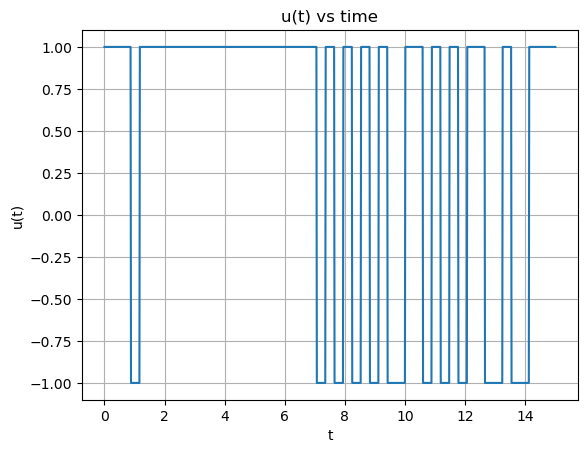

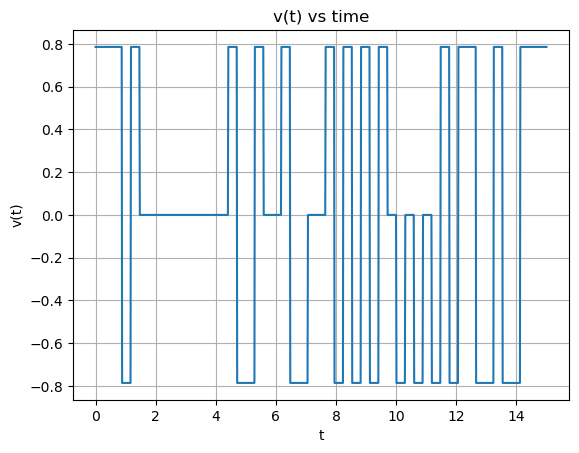

In [34]:
us=[2*(0.5-i%2) for i in u_t]
vs=[(1-i//2)*np.pi/4 for i in u_t]

u=[]
v=[]
for i in range(len(us)):
    for j in range(20):
        u.append(us[i])
        v.append(vs[i])
        
x = np.linspace(0, T, (N+1)*20)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

## Last Trajectory


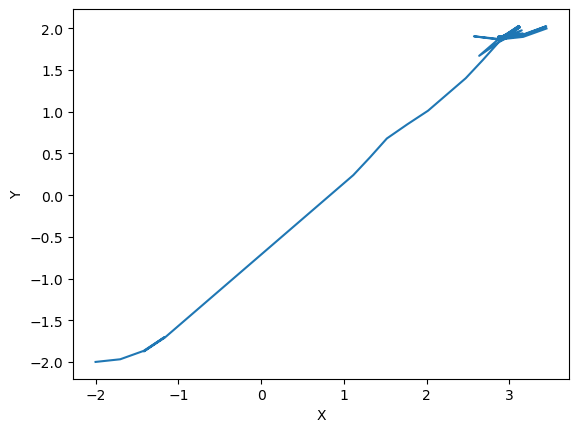

In [35]:
obs=np.array(observation_t)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

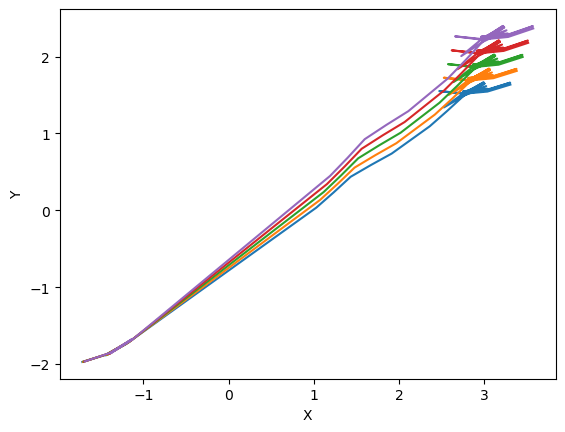

2.5825474809272255


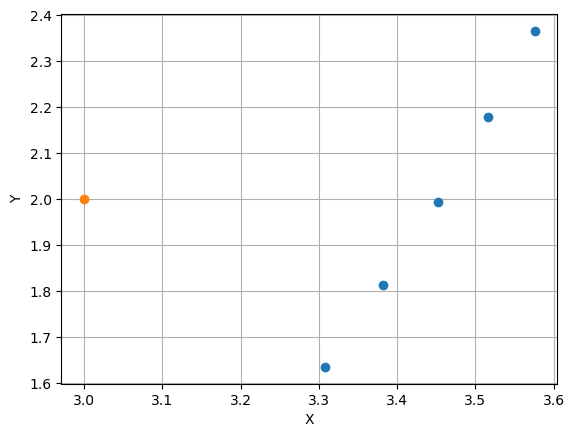

In [36]:
pos=[]
for i in range(num_system):
    obs=np.array(position_t[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(reward_raw(np.array(pos)))

cord_x=[]
cord_y=[]
for i in range(num_system):
    cord_x.append(pos[i][0])
    cord_y.append(pos[i][1])
plt.plot(np.array(cord_x),np.array(cord_y), 'o')
plt.plot(np.array([3]),np.array([2]), 'o')
#plt.plot(obs[-1,0],obs[-1,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()


## Best Trajectory

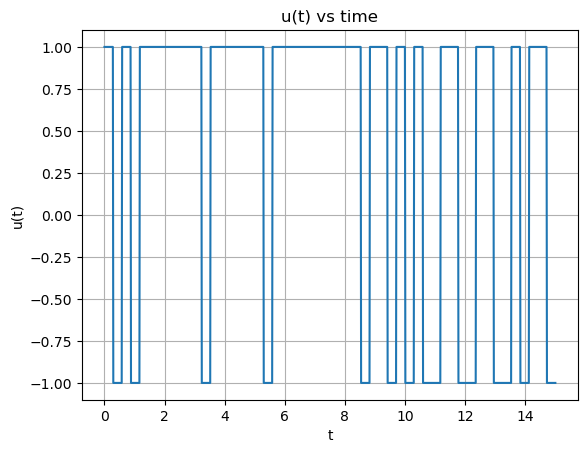

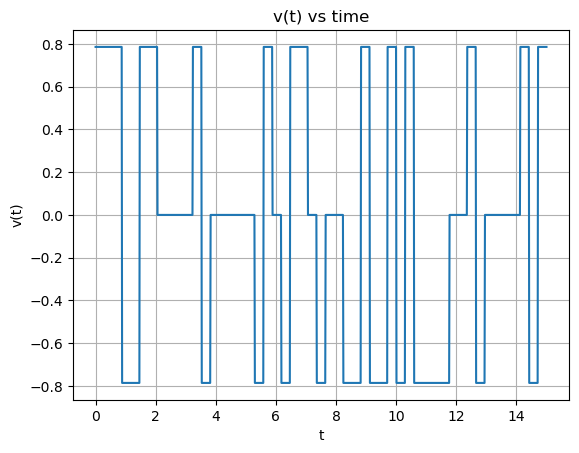

In [37]:
us=[2*(0.5-i%2) for i in best_u]
vs=[(1-i//2)*np.pi/4 for i in best_u]

u=[]
v=[]
for i in range(len(us)):
    for j in range(20):
        u.append(us[i])
        v.append(vs[i])

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

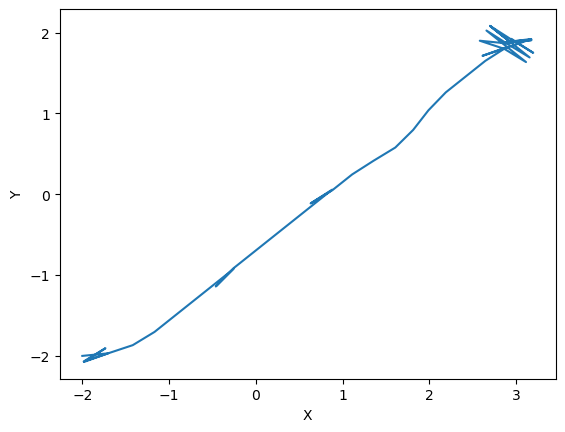

In [38]:
obs=np.array(best_obs)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

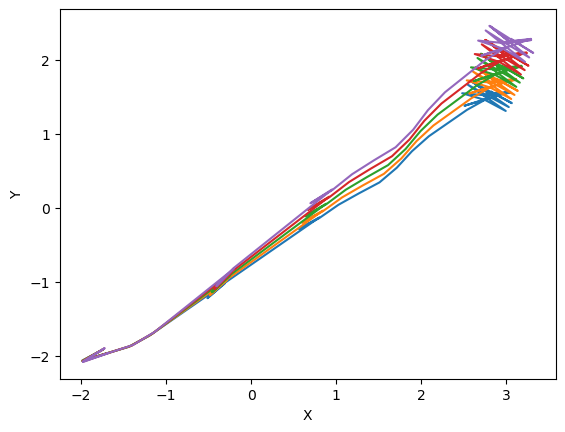

1.224302258772751


In [39]:
pos=[]
for i in range(num_system):
    obs=np.array(best_pos[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(reward_raw(np.array(pos)))

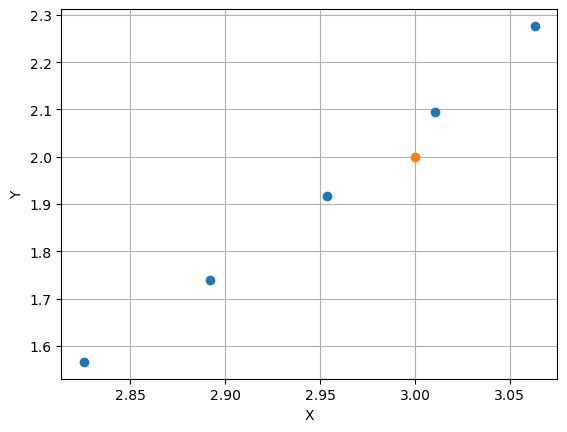

In [40]:
pos=[]
for i in range(num_system):
    obs=np.array(best_pos[i])
    obs=obs[:,[0,1]]
    #plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])

cord_x=[]
cord_y=[]
for i in range(num_system):
    cord_x.append(pos[i][0])
    cord_y.append(pos[i][1])
plt.plot(np.array(cord_x),np.array(cord_y), 'o')
plt.plot(np.array([3]),np.array([2]), 'o')
#plt.plot(obs[-1,0],obs[-1,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()

## Pure Exploitation Trajectory

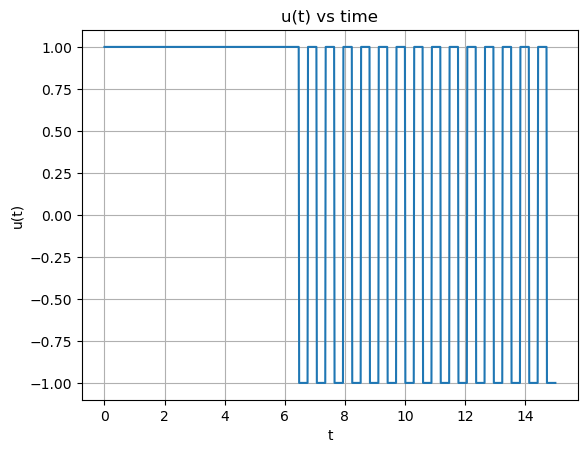

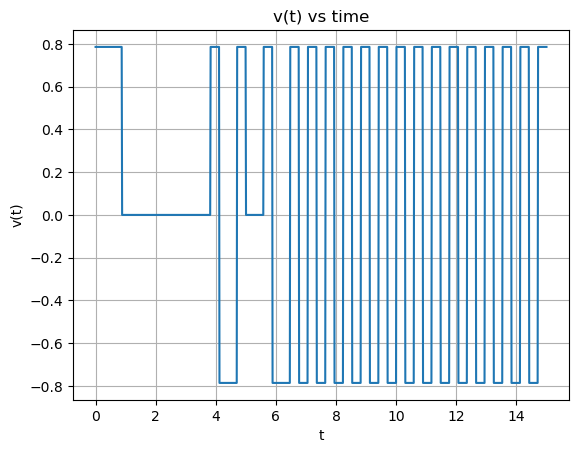

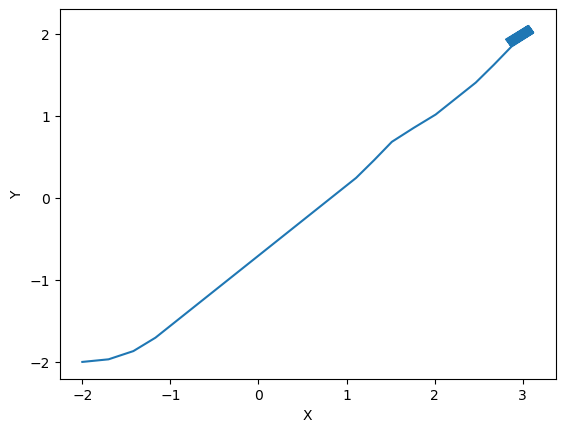

In [41]:
position=np.array([[-2,-2,0] for _ in range(num_system)])
observation=observe(position)
u_t=[]
observation_t=[observation]
position_t=[[] for i in range(num_system)]

for time in range(N+1):           
    
    #print(candidates_u)
    u_k = decide_u_exploitation(gpr_list[time],flags,observation)
    position_new = next_step(position,action_set[u_k])
    observation_new = observe(position_new)
    r = reward(observation_new)
    '''
    if explo:
        history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,5)))
        history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
    '''
    observation=observation_new
    position=position_new
    u_t.append(u_k)
    observation_t.append(observation)
    for i in range(num_system):
        position_t[i].append(position[i])
    '''
    if time%((N+1)//3+1)==0:
        for i in range(6):
            gpr_list[i]=GaussianProcessRegressor(alpha=1e-8).fit(history_su[i], history_r[i].reshape(-1,1))
    '''
    
us=[2*(0.5-i%2) for i in u_t]
vs=[(1-i//2)*np.pi/4 for i in u_t]

u=[]
v=[]
for i in range(len(us)):
    for j in range(20):
        u.append(us[i])
        v.append(vs[i])
    

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

obs=np.array(observation_t)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

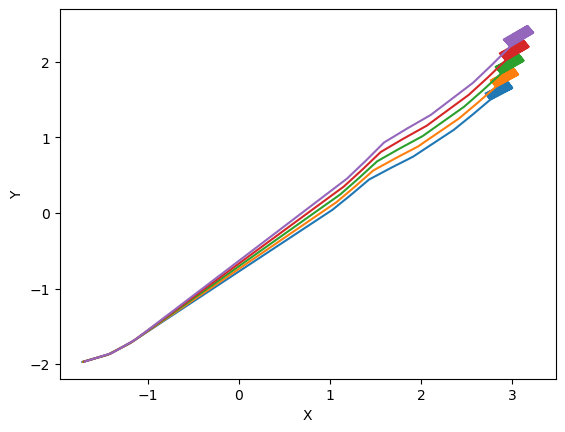

1.5236632154551701


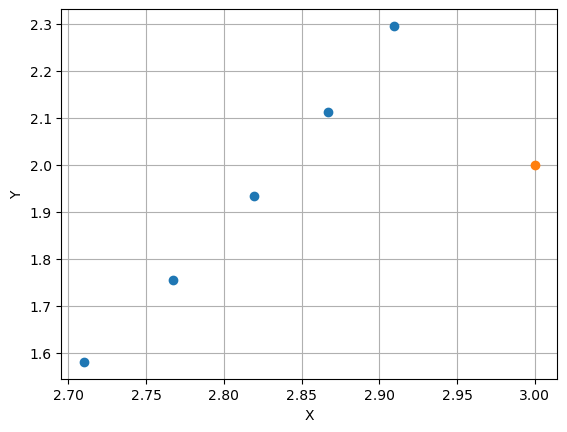

In [42]:
pos=[]
for i in range(num_system):
    obs=np.array(position_t[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(reward_raw(position))

cord_x=[]
cord_y=[]
for i in range(num_system):
    cord_x.append(pos[i][0])
    cord_y.append(pos[i][1])
plt.plot(np.array(cord_x),np.array(cord_y), 'o')
plt.plot(np.array([3]),np.array([2]), 'o')
#plt.plot(obs[-1,0],obs[-1,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()